### run this notebook for each patient following Plastimatch DIR and calculation of the Jacobian determinant

In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
from os.path import expanduser
import glob
from matplotlib.ticker import MaxNLocator
from scipy.stats import spearmanr
import seg_metrics.seg_metrics as sg
import pickle
from skimage import exposure
from scipy import ndimage
import nibabel as nib
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib import cm

In [2]:
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SITK version:", sitk.__version__)
print("Scikit-image version:", skimage.__version__)

Python version: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
Numpy version: 2.1.0
Matplotlib version: 3.9.2
SITK version: 2.4.0
Scikit-image version: 0.24.0


In [3]:
patient_id = 14

In [4]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)
PREPROCESSED_STACK_DIR = '{}/stack'.format(PREPROCESSED_BASE_DIR)

#### load the Plastimatch outputs

In [5]:
pm_exhale_im = sitk.ReadImage('{}/phase-exhale-nomask.mha'.format(PREPROCESSED_MHA_DIR))
jacobian_det_im = sitk.ReadImage('{}/vf_jac.mha'.format(PREPROCESSED_MHA_DIR))
pm_deformed_inhale_im = sitk.ReadImage('{}/deformed.mha'.format(PREPROCESSED_MHA_DIR))
pm_mask_exhale_im = sitk.ReadImage('{}/mask-exhale.mha'.format(PREPROCESSED_MHA_DIR))

In [6]:
size_exp = pm_exhale_im.GetSize()
spacing_exp = pm_exhale_im.GetSpacing()
origin_exp = pm_exhale_im.GetOrigin()

print("Image size EXP:", str(size_exp[0]), str(size_exp[1]), str(size_exp[2]))
print("Spacing (mm):", str(spacing_exp[0]), str(spacing_exp[1]), str(spacing_exp[2]))
print("Origin (mm):", str(origin_exp[0]), str(origin_exp[1]), str(origin_exp[2]))

Image size EXP: 512 512 167
Spacing (mm): 0.9765625 0.9765625 1.7999999999999998
Origin (mm): -249.51171875 -451.51171875 -527.0


In [7]:
pm_exhale_arr = sitk.GetArrayFromImage(pm_exhale_im)
jacobian_det_arr = sitk.GetArrayFromImage(jacobian_det_im)
pm_deformed_inhale_arr = sitk.GetArrayFromImage(pm_deformed_inhale_im)
pm_mask_exhale_arr = sitk.GetArrayFromImage(pm_mask_exhale_im).astype(bool)

#### load the PET ground truth (unquantised and quantised)

In [8]:
output_name = '{}/Patient{:02d}.npy'.format(PREPROCESSED_STACK_DIR, patient_id)
pt_arr = np.load(output_name)
print('loaded stack from {}'.format(output_name))

exp_arr = pt_arr[0]
insp_arr = pt_arr[1]
pet_arr = pt_arr[2]
pet_labels_arr = pt_arr[3]
exh_mask_arr = pt_arr[4].astype(bool)

loaded stack from /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/stack/Patient14.npy


In [9]:
exh_mask_arr.shape

(300, 320, 320)

#### apply the mask to the images from Plastimatch

In [10]:
pm_exhale_arr = np.where((pm_mask_exhale_arr==True), pm_exhale_arr, 1e-3)
jacobian_det_arr = np.where((pm_mask_exhale_arr==True), jacobian_det_arr, 1e-3)
pm_deformed_inhale_arr = np.where((pm_mask_exhale_arr==True), pm_deformed_inhale_arr, 1e-3)

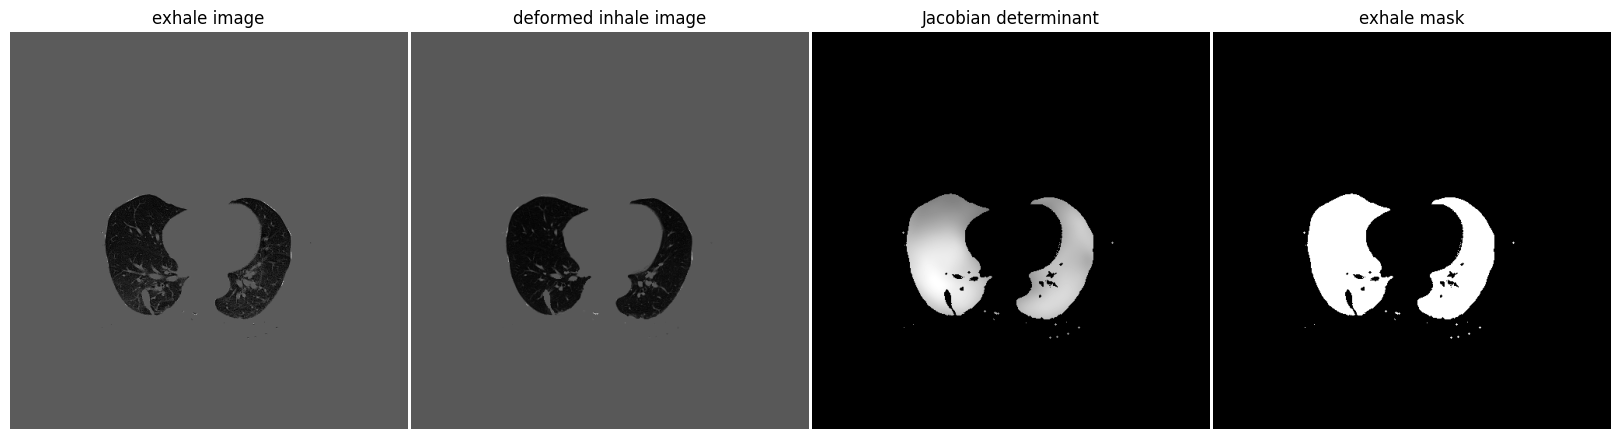

In [11]:
DISPLAY_IDX = 100

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(pm_exhale_arr[DISPLAY_IDX], cmap="gray")
ax1.set_title('exhale image')
ax1.set_axis_off()

ax2.imshow(pm_deformed_inhale_arr[DISPLAY_IDX], cmap="gray")
ax2.set_title('deformed inhale image')
ax2.set_axis_off()

ax3.imshow(jacobian_det_arr[DISPLAY_IDX], cmap="gray")
ax3.set_title('Jacobian determinant')
ax3.set_axis_off()

ax4.imshow(pm_mask_exhale_arr[DISPLAY_IDX], cmap="gray")
ax4.set_title('exhale mask')
ax4.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

#### calculate the CTVI-Jac

In [12]:
ctvi_jac_arr = jacobian_det_arr-1.0

#### calculate the CTVI-HU

In [13]:
# rescale for air and water
airHU = -1000. + 1
waterHU = 0.

pm_exhale_arr = exposure.rescale_intensity(pm_exhale_arr, in_range='image', out_range=(airHU, waterHU))
deformed_inhale_arr = exposure.rescale_intensity(pm_deformed_inhale_arr, in_range='image', out_range=(airHU, waterHU))

In [14]:
np.min(pm_exhale_arr), np.max(pm_exhale_arr)

(np.float64(-999.0), np.float64(0.0))

In [15]:
tissue_density_scaling_factor_arr = (pm_exhale_arr + 1000) / 1000
ctvi_hu_arr = (pm_exhale_arr - deformed_inhale_arr) / (deformed_inhale_arr + 1000) * tissue_density_scaling_factor_arr

In [16]:
np.min(ctvi_hu_arr), np.max(ctvi_hu_arr)

(np.float64(-0.2499551541649559), np.float64(53.19278437332272))

#### resample, crop, & pad the CTVIs so we can make a comparison with model predictions

In [17]:
# Resampling the images into (1,1,1)mm voxel size. Can use nearest neighbour for interpolation (default is B-spline). 
def resample_image(itk_image, out_spacing=(1.0, 1.0, 1.0), is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [18]:
def array_to_image(arr, spacing, origin):
    im = sitk.GetImageFromArray(arr)
    im.SetSpacing(spacing)
    im.SetOrigin(origin)
    return im

In [19]:
# convert numpy arrays to images for resampling, preserving their spacing and origin
ctvi_jac_im = array_to_image(ctvi_jac_arr, spacing=spacing_exp, origin=origin_exp)
ctvi_hu_im = array_to_image(ctvi_hu_arr, spacing=spacing_exp, origin=origin_exp)

In [20]:
# resample the CTVIs
ctvi_jac_im_resampled = resample_image(ctvi_jac_im)
ctvi_hu_im_resampled = resample_image(ctvi_hu_im)

In [21]:
# convert back into numpy array after resampling
ctvi_jac_arr = sitk.GetArrayFromImage(ctvi_jac_im_resampled)
ctvi_hu_arr = sitk.GetArrayFromImage(ctvi_hu_im_resampled)

In [22]:
ctvi_jac_arr.shape, ctvi_hu_arr.shape

((301, 500, 500), (301, 500, 500))

#### pad and crop

In [23]:
TARGET_SIZE_X = 320
TARGET_SIZE_Y = 320
TARGET_SIZE_Z = 300

In [24]:
def adjust_dims(arr):
    # pad z axis if needed
    if arr.shape[0] < TARGET_SIZE_Z:
        pad_slices = TARGET_SIZE_Z - arr.shape[0]
        arr = np.pad(arr, pad_width=((0,pad_slices),(0,0),(0,0)), mode='constant', constant_values=np.min(arr))  # pad at the back
    
    # crop x and y axes of CT
    crop_x_lower = int(np.round((arr.shape[2]-TARGET_SIZE_X)/2)); crop_x_upper = crop_x_lower+TARGET_SIZE_X
    crop_y_lower = int(np.round((arr.shape[1]-TARGET_SIZE_Y)/2)); crop_y_upper = crop_y_lower+TARGET_SIZE_Y
    crop_z_lower = int(np.round((arr.shape[0]-TARGET_SIZE_Z)/2)); crop_z_upper = crop_z_lower+TARGET_SIZE_Z
    
    arr = arr[crop_z_lower:crop_z_upper, crop_y_lower:crop_y_upper, crop_x_lower:crop_x_upper]
    return arr

In [25]:
ctvi_jac_arr = adjust_dims(ctvi_jac_arr)
ctvi_hu_arr = adjust_dims(ctvi_hu_arr)

In [26]:
ctvi_jac_arr.shape, ctvi_hu_arr.shape

((300, 320, 320), (300, 320, 320))

In [27]:
np.min(ctvi_hu_arr), np.max(ctvi_hu_arr)

(np.float64(-5.96163261061848), np.float64(40.04778796313264))

#### rescale

In [28]:
ctvi_jac_arr = exposure.rescale_intensity(ctvi_jac_arr, in_range='image', out_range=(1e-3,1.))
ctvi_hu_arr = exposure.rescale_intensity(ctvi_hu_arr, in_range='image', out_range=(1e-3,1.))

#### apply a median filter

In [29]:
ctvi_jac_arr = ndimage.median_filter(ctvi_jac_arr, size=7, mode='nearest')
ctvi_hu_arr = ndimage.median_filter(ctvi_hu_arr, size=7, mode='nearest')

In [30]:
np.min(ctvi_hu_arr), np.max(ctvi_hu_arr)

(np.float64(0.12876670893833891), np.float64(0.14364522248433922))

### compare unquantised CTVIs with PET ground truth

In [31]:
DISPLAY_IDX = 150

saved figure to /home/daryl/figures/ct-pet-ctvi-dir-unquantised-P14.png


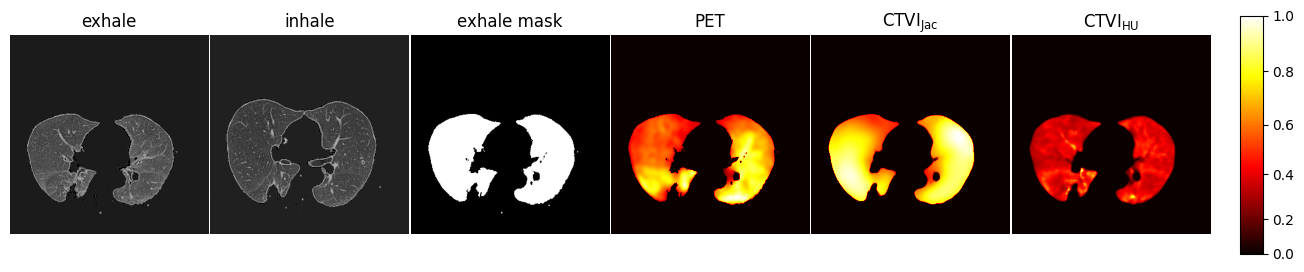

In [32]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(15,7))

exp_slice = exp_arr[DISPLAY_IDX]
ax1.imshow(exp_slice, cmap="gray", norm=colors.PowerNorm(0.5, vmin=np.percentile(exp_slice,1)))
ax1.set_title('exhale')
ax1.set_axis_off()

insp_slice = insp_arr[DISPLAY_IDX]
ax2.imshow(insp_slice, cmap="gray", norm=colors.PowerNorm(0.5, vmin=np.percentile(insp_slice,1)))
ax2.set_title('inhale')
ax2.set_axis_off()

mask_slice = exh_mask_arr[DISPLAY_IDX]
ax3.imshow(mask_slice, cmap="gray")
ax3.set_title('exhale mask')
ax3.set_axis_off()

pet_slice = pet_arr[DISPLAY_IDX]
ax4.imshow(pet_slice, cmap="hot", norm=colors.PowerNorm(0.8))
ax4.set_title('PET')
ax4.set_axis_off()

ctvi_jac_slice = ctvi_jac_arr[DISPLAY_IDX]
ax5.imshow(ctvi_jac_slice, cmap="hot", norm=colors.PowerNorm(1.8))
ax5.set_title(r'CTVI$_\text{Jac}$')
ax5.set_axis_off()

ctvi_hu_slice = ctvi_hu_arr[DISPLAY_IDX]
ax6.imshow(ctvi_hu_slice, cmap="hot")
ax6.set_title(r'CTVI$_\text{HU}$')
ax6.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=0.75, fontsize=12, ha='left')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.92, 0.33, 0.015, 0.34])
fig.colorbar(cm.ScalarMappable(norm=colors.PowerNorm(1.2, vmin=0, vmax=1), cmap='hot'), cax=cbar_ax, orientation='vertical', format='%0.1f')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

fig_filename = '{}/figures/ct-pet-ctvi-dir-unquantised-P{:02d}.png'.format(expanduser('~'), patient_id)
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

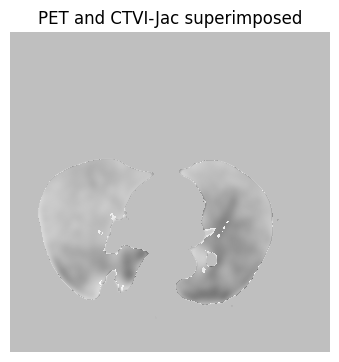

In [33]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15,4))
ax1.imshow(ctvi_jac_arr[DISPLAY_IDX], cmap="gist_gray", alpha=0.5)
ax1.imshow(pet_arr[DISPLAY_IDX], cmap="gist_yarg", alpha=0.5)
ax1.set_title('PET and CTVI-Jac superimposed')
ax1.set_axis_off()

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

In [34]:
pet_arr.shape

(300, 320, 320)

In [35]:
sp_jac = spearmanr(ctvi_jac_arr[exh_mask_arr], pet_arr[exh_mask_arr], axis=None)
sp_hu = spearmanr(ctvi_hu_arr[exh_mask_arr], pet_arr[exh_mask_arr], axis=None)
print('Spearman (P{:02d})\n{}, p-value {} (Jac)\n{} p-value {} (HU)'.format(patient_id, np.round(sp_jac[0],2), np.round(sp_jac[1],2), np.round(sp_hu[0],2), np.round(sp_hu[1],2) ))
patient_eval_d = {'spearman_correlation_jac':sp_jac[0], 'pval_jac':sp_jac[1], 'spearman_correlation_hu':sp_hu[0], 'pval_hu':sp_hu[1]}

Spearman (P14)
0.65, p-value 0.0 (Jac)
0.59 p-value 0.0 (HU)


#### save the results for overall analysis

In [36]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
EVALUATION_DIR = '{}/evaluation'.format(PREPROCESSED_BASE_DIR)
PATIENT_EVALUATION_DIR = '{}/Patient{:02d}'.format(EVALUATION_DIR, patient_id)

In [37]:
if not os.path.exists(EVALUATION_DIR):
    os.makedirs(EVALUATION_DIR)

if not os.path.exists(PATIENT_EVALUATION_DIR):
    os.makedirs(PATIENT_EVALUATION_DIR)

In [38]:
DATASET_EVALUATION_FILE = '{}/evaluation-unquantised.pkl'.format(EVALUATION_DIR)

if os.path.isfile(DATASET_EVALUATION_FILE):
    with open(DATASET_EVALUATION_FILE, 'rb') as f:
        dataset_d = pickle.load(f)
else:
    dataset_d = {}

dataset_d[patient_id] = patient_eval_d

with open(DATASET_EVALUATION_FILE, 'wb') as f:
        pickle.dump(dataset_d, f)

#### save the unquantised images 

In [39]:
UNQUANTISED_IMAGES_DIR = '{}/unquantised-images'.format(PREPROCESSED_BASE_DIR)
if not os.path.exists(UNQUANTISED_IMAGES_DIR):
    os.makedirs(UNQUANTISED_IMAGES_DIR)
PATIENT_UNQUANTISED_DIR = '{}/Patient{:02d}'.format(UNQUANTISED_IMAGES_DIR, patient_id)
if not os.path.exists(PATIENT_UNQUANTISED_DIR):
    os.makedirs(PATIENT_UNQUANTISED_DIR)

In [40]:
print('saving unquantised images to {}'.format(PATIENT_UNQUANTISED_DIR))
nib.Nifti1Image(np.transpose(exp_arr, (2,1,0)), np.eye(4)).to_filename('{}/exhale.nii.gz'.format(PATIENT_UNQUANTISED_DIR))
nib.Nifti1Image(np.transpose(insp_arr, (2,1,0)), np.eye(4)).to_filename('{}/inhale.nii.gz'.format(PATIENT_UNQUANTISED_DIR))
nib.Nifti1Image(np.transpose(exh_mask_arr, (2,1,0)).astype(np.int8), np.eye(4)).to_filename('{}/exhale-mask.nii.gz'.format(PATIENT_UNQUANTISED_DIR))
nib.Nifti1Image(np.transpose(pet_arr, (2,1,0)), np.eye(4)).to_filename('{}/unquantised-pet.nii.gz'.format(PATIENT_UNQUANTISED_DIR))
nib.Nifti1Image(np.transpose(ctvi_jac_arr, (2,1,0)), np.eye(4)).to_filename('{}/unquantised-ctvi-jac.nii.gz'.format(PATIENT_UNQUANTISED_DIR))
nib.Nifti1Image(np.transpose(ctvi_hu_arr, (2,1,0)), np.eye(4)).to_filename('{}/unquantised-ctvi-hu.nii.gz'.format(PATIENT_UNQUANTISED_DIR))

saving unquantised images to /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/unquantised-images/Patient14


### quantise the CTVI and save for the next step

#### quantise the CTVI-Jac

In [41]:
percentile_high_jac = np.percentile(ctvi_jac_arr[exh_mask_arr],70)
percentile_medium_jac = np.percentile(ctvi_jac_arr[exh_mask_arr],30)

In [42]:
percentile_high_jac,percentile_medium_jac

(np.float32(0.7199693), np.float32(0.6430834))

In [43]:
# we label voxels above the 70th percentile as 'high', between the 30th and 70th as 'medium', below the 30th as 'low', and outside the 
# mask as 'background'
ctvi_jac_label_high_arr = np.where((exh_mask_arr==True) & (ctvi_jac_arr>percentile_high_jac), 1 , 0)
ctvi_jac_label_medium_arr = np.where((exh_mask_arr==True) & (ctvi_jac_arr<=percentile_high_jac) & (ctvi_jac_arr>=percentile_medium_jac), 2 , 0)
ctvi_jac_label_low_arr = np.where((exh_mask_arr==True) & (ctvi_jac_arr<percentile_medium_jac), 3 , 0)

ctvi_jac_label_arr = ctvi_jac_label_high_arr + ctvi_jac_label_medium_arr + ctvi_jac_label_low_arr

#### quantise the CTVI-HU

In [44]:
percentile_high_hu = np.percentile(ctvi_hu_arr[exh_mask_arr],70)
percentile_medium_hu = np.percentile(ctvi_hu_arr[exh_mask_arr],30)

In [45]:
percentile_high_hu,percentile_medium_hu

(np.float64(0.1310380757783637), np.float64(0.13060606121637658))

In [46]:
# we label voxels above the 70th percentile as 'high', between the 30th and 70th as 'medium', below the 30th as 'low', and outside the 
# mask as 'background'
ctvi_hu_label_high_arr = np.where((exh_mask_arr==True) & (ctvi_hu_arr>percentile_high_hu), 1 , 0)
ctvi_hu_label_medium_arr = np.where((exh_mask_arr==True) & (ctvi_hu_arr<=percentile_high_hu) & (ctvi_hu_arr>=percentile_medium_hu), 2 , 0)
ctvi_hu_label_low_arr = np.where((exh_mask_arr==True) & (ctvi_hu_arr<percentile_medium_hu), 3 , 0)

ctvi_hu_label_arr = ctvi_hu_label_high_arr + ctvi_hu_label_medium_arr + ctvi_hu_label_low_arr

#### visualise the images

In [47]:
labels_d = {0:'background', 1:'high', 2:'medium', 3:'low'}

# set up the colour map
colours_d = {
    0: 'black',
    1: 'lime',
    2: 'lightseagreen',
    3: 'slategray'
}

cm = ListedColormap(colours_d.values())

saved figure to /home/daryl/figures/ct-pet-ctvi-dir-quantised-P14.png


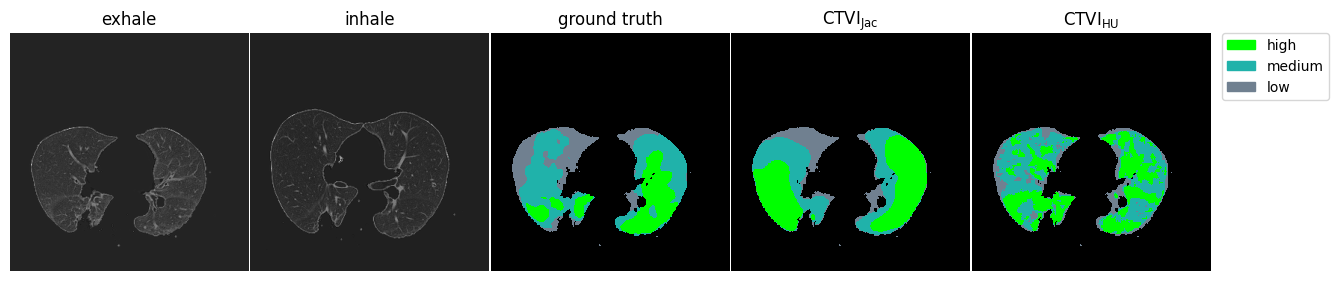

In [48]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,7))
ax1.imshow(exp_arr[DISPLAY_IDX], cmap="gray")
ax1.set_title('exhale')
ax1.set_axis_off()

ax2.imshow(insp_arr[DISPLAY_IDX], cmap="gray")
ax2.set_title('inhale')
ax2.set_axis_off()

ax3.imshow(pet_labels_arr[DISPLAY_IDX], cmap=cm, interpolation='none')
ax3.set_title('ground truth')
ax3.set_axis_off()

ax4.imshow(ctvi_jac_label_arr[DISPLAY_IDX], cmap=cm, interpolation='none')
ax4.set_title(r'CTVI$_\text{Jac}$')
ax4.set_axis_off()

ax5.imshow(ctvi_hu_label_arr[DISPLAY_IDX], cmap=cm, interpolation='none')
ax5.set_title(r'CTVI$_\text{HU}$')
ax5.set_axis_off()

# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colours_d[i], label="{l}".format(l=labels_d[i]) ) for i in [1,2,3] ]
legend = plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

fig_filename = '{}/figures/ct-pet-ctvi-dir-quantised-P{:02d}.png'.format(expanduser('~'), patient_id)
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

In [49]:
params = {}
params['font.size'] = 18
params['figure.dpi'] = 150
params['figure.figsize'] = 1,1.5

plt.rcParams.update(params)

saved figure to /home/daryl/figures/ctvi-predictions-legend.png


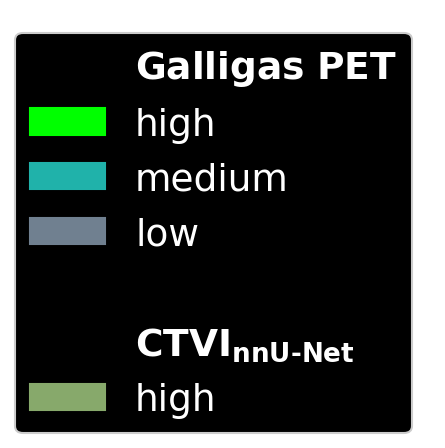

In [50]:
fig, ax = plt.subplots()

# create a patch (proxy artist) for every color
colours_d[4] = '#87a96b'
labels_d[4] = 'high'
patches = []
x = y = 0
patches.append(mpatches.Patch(color='black', label=r'$\bf{Galligas\ PET}$', visible=False))
for i in [1,2,3]:
    patches.append(mpatches.Patch(color=colours_d[i], label="{l}".format(l=labels_d[i])))
patches.append(mpatches.Patch(color='black', label="", visible=False))
patches.append(mpatches.Patch(color='black', label=r'$\bf{CTVI_{nnU'+u'\u2010'+'Net}}$', visible=False))
for i in [4]:
    patches.append(mpatches.Patch(color=colours_d[i], label="{l}".format(l=labels_d[i])))
legend = plt.legend(handles=patches, facecolor='black', labelcolor='w', framealpha=1)
# frame = legend.get_frame()
# frame.set_facecolor('black')
# frame.set_edgecolor('black')
plt.gca().set_axis_off()

expand=[0,0,0,0]
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

fig_filename = '{}/figures/ctvi-predictions-legend.png'.format(expanduser('~'))
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches=bbox)
print('saved figure to {}'.format(fig_filename))

#### write out the quantised CTVI for comparison

In [51]:
sitk.WriteImage(sitk.GetImageFromArray(ctvi_jac_label_arr), '{}/ctvi-jac-label.mha'.format(PREPROCESSED_MHA_DIR))
sitk.WriteImage(sitk.GetImageFromArray(ctvi_hu_label_arr), '{}/ctvi-hu-label.mha'.format(PREPROCESSED_MHA_DIR))

#### save the quantised images 

In [52]:
QUANTISED_IMAGES_DIR = '{}/quantised-images'.format(PREPROCESSED_BASE_DIR)
if not os.path.exists(QUANTISED_IMAGES_DIR):
    os.makedirs(QUANTISED_IMAGES_DIR)
PATIENT_QUANTISED_DIR = '{}/Patient{:02d}'.format(QUANTISED_IMAGES_DIR, patient_id)
if not os.path.exists(PATIENT_QUANTISED_DIR):
    os.makedirs(PATIENT_QUANTISED_DIR)

In [53]:
print('saving quantised images to {}'.format(PATIENT_QUANTISED_DIR))
nib.Nifti1Image(np.transpose(exp_arr, (2,1,0)), np.eye(4)).to_filename('{}/exhale.nii.gz'.format(PATIENT_QUANTISED_DIR))
nib.Nifti1Image(np.transpose(insp_arr, (2,1,0)), np.eye(4)).to_filename('{}/inhale.nii.gz'.format(PATIENT_QUANTISED_DIR))
nib.Nifti1Image(np.transpose(exh_mask_arr, (2,1,0)).astype(np.int8), np.eye(4)).to_filename('{}/exhale-mask.nii.gz'.format(PATIENT_QUANTISED_DIR))
nib.Nifti1Image(np.transpose(pet_labels_arr, (2,1,0)).astype(np.int8), np.eye(4)).to_filename('{}/quantised-pet.nii.gz'.format(PATIENT_QUANTISED_DIR))
nib.Nifti1Image(np.transpose(ctvi_jac_label_arr, (2,1,0)).astype(np.int8), np.eye(4)).to_filename('{}/quantised-ctvi-jac.nii.gz'.format(PATIENT_QUANTISED_DIR))
nib.Nifti1Image(np.transpose(ctvi_hu_label_arr, (2,1,0)).astype(np.int8), np.eye(4)).to_filename('{}/quantised-ctvi-hu.nii.gz'.format(PATIENT_QUANTISED_DIR))

saving quantised images to /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/quantised-images/Patient14
